# **Hand On!**

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/27<br>
**Last modified:** 2022/11/10<br>
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
 classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.

## Setup

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers



In [3]:

tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Limita la memoria GPU a una percentuale specifica
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]  # Imposta il limite in megabyte
        )
    except RuntimeError as e:
        print(e)






## Load the data: the Cats vs Dogs dataset

### Raw data download

First, let's download the 786M ZIP archive of the raw data:

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

In [ ]:

!tar -xf kagglecatsanddogs_5340.zip

# Per linux
#!unzip -q kagglecatsanddogs_5340.zip

Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
 subfolder contains image files for each category.

In [ ]:
!dir PetImages

# Per linux
#Crea 

### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
in their header.

In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

## Generate a `Dataset`

In [6]:
image_size = (180, 180)
batch_size = 128

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"
and label 0 is "cat".

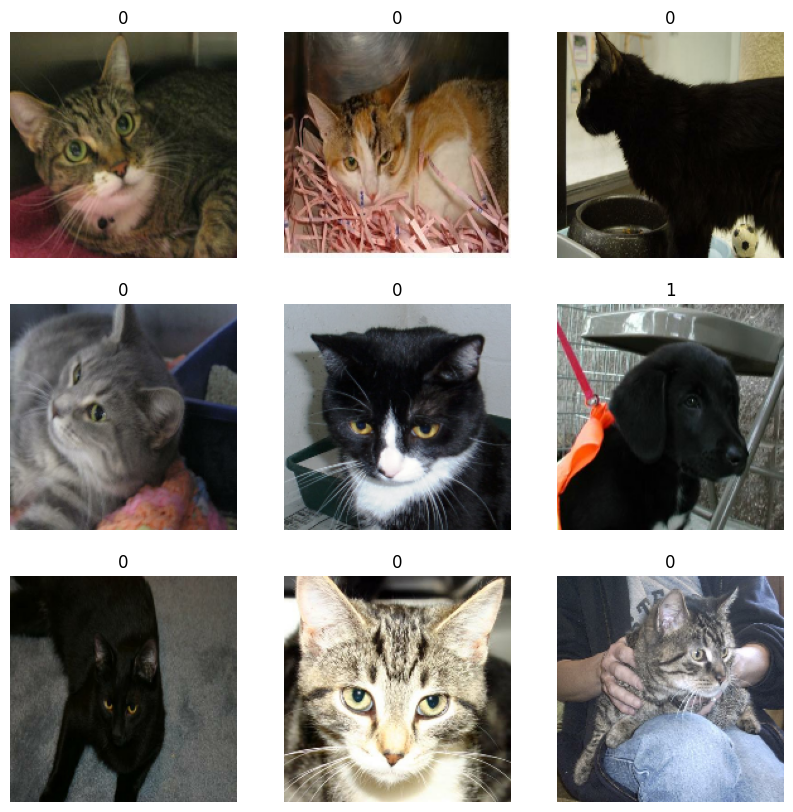

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
overfitting.

In [7]:
from keras import *

data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.2),
    ]
)


Let's visualize what the augmented samples look like, by applying `data_augmentation`
repeatedly to the first image in the dataset:

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")



## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
our model.

0.035838805 1.0


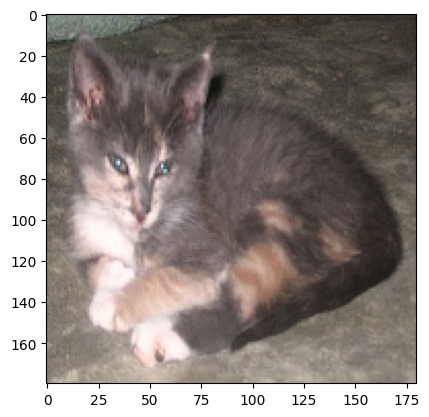

In [10]:
## Standardizing the data

#Our image are already in a standard size (180x180), as they are being yielded as
#contiguous `float32` batches by our dataset. However, their RGB channel values are in
#the `[0, 255]` range. This is not ideal for a neural network;
#in general you should seek to make your input values small. Here, we will
#standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
#our model.

from keras import layers
import numpy as np

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(normalized_ds))

first_image = image_batch[0]

# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

#show augmented first image channel value

plt.imshow(first_image)




## Build a model

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.

In [11]:
# Create the model
## Build a model


#- We start the model with the `data_augmentation` preprocessor, followed by a
# `Rescaling` layer.
#- We include a `Dropout` layer before the final classification layer.

num_classes = 2

model = keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

## Train the model

In [ ]:
# Train model 

model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

# Visualize training resultsd

In [ ]:
# Plot the results for loss 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the results for accuracy

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')

# Plot the results for loss

plt.subplot(2, 1, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')

plt.show()


We get to >90% validation accuracy after training for 25 epochs on the full dataset
(in practice, you can train for 50+ epochs before validation performance starts degrading).

In [15]:
from keras.models import load_model

#load model
new_model = load_model('cats_and_dogs_augmented.h5', compile=False)

In [ ]:
#compile model
new_model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])


## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.

In [52]:
#How to try with new data


#Download 10 images of cats and dogs from internet


class_names = train_ds.class_names

print(f"Class names: {class_names}")

# Download this in windows https://web.whatsapp.com/240ae270-2159-4631-aecf-0997c6fdc130 and save as sophie
#-o serve 

donwloadlink = "https://www.litter-robot.com/media/wysiwyg/abyssinian-cat7.png"
!curl -o cat.jpg $donwloadlink
images = [
    "cat.jpg",
]




predictions = []

for image in images:    
    #QAuesto serve a caricare l'immagine
    img = keras.preprocessing.image.load_img(
        image, target_size=image_size
    )
    #Image to array
    img_array = keras.preprocessing.image.img_to_array(img)

    # Espendiamo le dimensioni 
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    # Predict
    preds = new_model.predict(img_array)

    #Write the predicted clas and confidence
    predicted_class = class_names[np.argmax(preds)]
    confidence = np.max(preds) * 100

    #Append
    predictions.append({
        'image': image,
        'predicted_class': predicted_class,
        'confidence': confidence
    })

# Print predictions
for prediction in predictions:
    print(f"{prediction['image']} - {prediction['predicted_class']} - {prediction['confidence']}%")

Class names: ['Cat', 'Dog']


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  863k    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  863k  100  863k    0     0   550k      0  0:00:01  0:00:01 --:--:--  551k


1/1 [==============================] - 0s 26ms/step
cat.jpg - Cat - 28.446713089942932%
